# Capstone: Topic Modelling on AMD vs Nvidia GPU

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA Analysis](#Prepare-data-for-LDA-Analysis)
- [LDA Model Training](#LDA-Model-Training)
- Model creation
- Model Evaluation

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import os

import re
# NLTK Library
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Gensim library
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

# Data Extraction from Amazon GPU using Selenium 

In [4]:
# Imports the webdriver and the Keys, Keys are used for Return, F1
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import NoSuchElementException
import time 

In [5]:
# Create a Dataframe to hold the data
GPU_df = pd.DataFrame(columns=['id','GPU Name','Manufacturer', 'Chipset Brand','Memory Size', 'Memory Speed(MHz)' , 'Price', 
                       'Overall Customer Rating', 'Customer Review Title', 
                       'Customer Review'])
GPU_df

,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,Customer Review Title,Customer Review


## Creating the function to scrap the data from Amazon

In [ ]:
def scrape_amzn_gpu(no_page, no_gpu, no_review_page):
    """
    This function scraps the GPUs information from the Amazon website
    no_page: Number of pages to go through, minimum must be 2
    no_gpu: Number of GPU information to extract per page
    no_review_page: Number of review pages per GPU to extract
    """
    # Create the Chrome Driver object
    driver = webdriver.Chrome()

    # Id for GPU tracking
    ids = 1

    # To keep track of the last entry appended for the review titles and body and the rating
    idx_title = 0
    idx_body = 0
    idx_star = 0

    for page in range(1,no_page):
        # Gets the first page of the website
        driver.get(f'https://www.amazon.com/s?k=Computer+Graphics+Cards&i=computers&rh=n:284822&page={page}&_encoding=UTF8&c=ts&qid=1608032958&ts_id=284822')
        main_url = driver.current_url

        # Check for sponsored post
        sponsored_posts = driver.find_elements_by_xpath('//div[@data-component-type="sp-sponsored-result"]/../../../..')
        lst_index_sponsored = []
        # Loop through the sponsored posts to find the index of the sponsored product
        for post in sponsored_posts:
            lst_index_sponsored.append(int(post.get_attribute('data-index')))

        n = 0 # index number

        # Scrap n GPUs in the first page
        while n < no_gpu:

            # If the index is in sponsored list
            while n in lst_index_sponsored:
                print(f'{n} index is a Sponsored Product, will skip to the next product')
                n += 1

            # Wait for 1 seconds
            time.sleep(1)

            try:
                # Click the link for the nth GPU
                driver.find_element_by_xpath(f'//div[@data-index={str(n)}]//a[@class="a-link-normal a-text-normal"]').click()
            except NoSuchElementException:
                break

            # Gets the url of the main page of the GPU
            gpu_url = driver.current_url

            # Click on the "See all reviews" link
            try:
                driver.find_element_by_xpath('//a[@data-hook="see-all-reviews-link-foot"]').click()
            except NoSuchElementException:
                n += 1
                # Go back to the main page
                driver.get(main_url)
                continue # Go back to the start of the while loop

            # Wait for 1 seconds
            time.sleep(1)


            """
            Loop through the review page and obtain the review title, review body, ratings
            """

            # Number of review pages to loop through for each GPU
            for review_page in range(no_review_page):

                # Gets the title of the reviews for each page, selects only the first span if there are multiple spans
                title_comment = driver.find_elements_by_xpath('//*[@data-hook = "review-title"]/span[1]')

                # Gets the customer reviews for each page
                review_body = driver.find_elements_by_xpath('//*[@data-hook = "review-body"]')


                # Loop through the title comments and append it to the Customer Review Title
                for title in title_comment:
                    GPU_df.loc[idx_title, 'Customer Review Title'] = title.text
                    idx_title += 1
                    #print(f'Customer review title is {title.text}')

                # Gets the review_bodies in the page and stores them in a list
                review_list = [review.text for review in review_body]


                # Loop through the review comments and append it to the Customer Review
                for review in review_list:
                    GPU_df.loc[idx_body, 'Customer Review'] = review
                    idx_body += 1

                # Sleep
                time.sleep(1)

                # Goes to the next review page   
                try:
                    driver.find_element_by_xpath('//li[@class="a-last"]/a').click()
                    # Sleep
                    time.sleep(3)
                # If not break out of the loop, and go back to the GPU main page
                except NoSuchElementException:
                    break




            """
            Fill up the null values with their respective attributes
            """

            # Go back to the GPU main page
            driver.get(gpu_url)

            # Wait for 2 seconds
            time.sleep(2)

            # Fill up the null values with the GPU name
            GPU_df['GPU Name'].fillna(driver.find_element_by_xpath('//*[@id="productTitle"]').text, inplace=True)

            # Fill up the null values with the Chipset Brand
            try:
                chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Chipset Brand")]/../../td').text
                GPU_df['Chipset Brand'].fillna(chipset,inplace=True)
            except NoSuchElementException:
                GPU_df['Chipset Brand'].fillna(np.nan,inplace=True)

            # Fill up the null values with the Memory Size
            try:
                chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Graphics Card Ram Size")]/../../td').text
                GPU_df['Memory Size'].fillna(chipset,inplace=True)
            except NoSuchElementException:
                GPU_df['Memory Size'].fillna(np.nan,inplace=True)

            # Fill up the null values with the Memory Speed(MHz)
            try:
                chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Memory Speed")]/../../td').text
                GPU_df['Memory Speed(MHz)'].fillna(chipset,inplace=True)
            except NoSuchElementException:
                GPU_df['Memory Speed(MHz)'].fillna(np.nan,inplace=True)

            # Fill up the null values with the manufacturer name
            try:
                manufacturer = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_2"]/tbody//th[contains(text(),"Manufacturer")]/../td').text
                GPU_df['Manufacturer'].fillna(manufacturer, inplace=True)
            except NoSuchElementException:
                GPU_df['Manufacturer'].fillna(np.nan,inplace=True)

            # Fill up the null values with the Price
            try:
                GPU_df['Price'].fillna(driver.find_element_by_xpath('//*[@id="price_inside_buybox"]').text, inplace=True)
            except NoSuchElementException:
                 GPU_df['Price'].fillna(np.nan, inplace=True)

            # Fill up the null values with the Customer ratings
            try:
                # Gets the overall customer ratings
                GPU_df['Overall Customer Rating'].fillna(driver.find_element_by_xpath('//div[@id="averageCustomerReviews"]//span[@id="acrPopover"]').get_attribute('title'), inplace=True)
            except NoSuchElementException:
                GPU_df['Overall Customer Rating'].fillna(np.nan, inplace=True)

            # Fill the id of the GPU for tracking
            GPU_df['id'].fillna(ids,inplace=True)
            ids += 1

            print(f'Completed scraping for {n} index in page {page}')

            # Increases the index for the next GPU
            n += 1

            # Go back to the main page
            driver.get(main_url)

        print('*'*30)
        print(f'Completed scraping for page {page}')
        print('*'*30)

    # Close the browser session
    total_gpu = max(GPU_df['id'])
    print(f'Completed scraping {total_gpu} GPUs reviews for {no_page-1} pages')
    driver.quit()

In [ ]:
scrape_amzn_gpu(no_page=10, no_gpu=8, no_review_page=15)
# GPU_df.shape

In [ ]:
# Export to csv file
GPU_df.to_csv('./amazon dataset/gpu_df_1.csv')

# Data cleaning

## Removing the null values

In [6]:
# Read the existing csv file
GPU_df = pd.read_csv('./amazon dataset/gpu_df_1.csv')

In [7]:
# Check the dimensions of the data
GPU_df.shape

(2673, 11)

In [8]:
# Check for null values
GPU_df.isnull().sum()

Unnamed: 0                   0
id                           0
GPU Name                     0
Manufacturer                 0
Chipset Brand                0
Memory Size                  0
Memory Speed(MHz)          105
Price                        0
Overall Customer Rating      0
Customer Review Title        1
Customer Review              2
dtype: int64

In [9]:
# Drop all the null values related to review as there only 3 of them
GPU_df[GPU_df['Customer Review'].isnull()]

,Unnamed: 0,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,Customer Review Title,Customer Review
2232,2232,23.0,LINKUP {35 cm} PCIE 3.0/4.0 16x Shielded Extre...,PNY,NVIDIA,512 MB,1770 MHz,$68.96,4.2 out of 5 stars,Useful,NaN
2583,2583,35.0,EVGA GeForce GTX 1080 Ti Gaming 11GB GDDR5X iC...,PNY,NVIDIA,512 MB,NaN,$849.99,4.3 out of 5 stars,NaN,NaN


In [10]:
GPU_df.dropna(subset=['Customer Review'],inplace=True)

In [11]:
# There are 19 null values related to price 
GPU_df.isnull().sum()

Unnamed: 0                   0
id                           0
GPU Name                     0
Manufacturer                 0
Chipset Brand                0
Memory Size                  0
Memory Speed(MHz)          104
Price                        0
Overall Customer Rating      0
Customer Review Title        0
Customer Review              0
dtype: int64

In [ ]:
# Name of GPU with missing price
rx_5500XT = GPU_df[GPU_df['Price'].isnull()]['GPU Name'].unique()[0]
rx_5500XT

There is only 1 GPU without a price, I'll try to find a similar GPU model and impute the missing value with the price

In [ ]:
GPU_df[GPU_df['GPU Name'] == rx_5500XT]['GPU Name'].duplicated().sum()

It seems the GPU with prices filled with null are duplicated. I'll drop them as they contain duplicated review title and reviews.

In [12]:
GPU_df.dropna(subset=['Price'], inplace=True)

In [13]:
# All the null values are removed
GPU_df.isnull().sum()

Unnamed: 0                   0
id                           0
GPU Name                     0
Manufacturer                 0
Chipset Brand                0
Memory Size                  0
Memory Speed(MHz)          104
Price                        0
Overall Customer Rating      0
Customer Review Title        0
Customer Review              0
dtype: int64

## Drop the unnamed colum

In [26]:
GPU_df.drop('Unnamed: 0',axis=1,inplace=True)

In [27]:
GPU_df.head()

,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,Customer Review Title,Customer Review
0,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,Inexpensive and works great in my small-form-f...,I need a graphic card upgrade for a very old c...
1,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,"A Faster, More Powerful 10 Year-Old Gateway De...","I generally don't write reviews, but since I d..."
2,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,Fit like a dream,"Fit like a dream, worked easily, installation ..."
3,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,HDMI sound went out after 4 weeks,I use the 710 video card in my PC Windows 10 f...
4,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,Works just fine and plays Fortnite on lowest s...,I bought this for my son's PC as he wanted to ...


## Removing null values in Memory Speed (MHz)

In [17]:
GPU_df.dropna(subset=['Memory Speed(MHz)'], inplace=True)

In [18]:
GPU_df.isnull().sum()

Unnamed: 0                 0
id                         0
GPU Name                   0
Manufacturer               0
Chipset Brand              0
Memory Size                0
Memory Speed(MHz)          0
Price                      0
Overall Customer Rating    0
Customer Review Title      0
Customer Review            0
dtype: int64

## Removing the null values in Customer Review Title

In [14]:
(GPU_df['Customer Review Title'] == '').sum()

0

There are 2 null values in Customer Review Title, will have to remove them they're only 2 of them

In [15]:
GPU_df[GPU_df['Customer Review Title'] == '']

,Unnamed: 0,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,Customer Review Title,Customer Review


In [16]:
GPU_df.drop(GPU_df[GPU_df['Customer Review Title'] == ''].index, inplace=True)

## Removing the non-gpus

In [19]:
GPU_df['GPU Name'].unique()

array(['MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDCP Support DirectX 12 OpenGL 4.5 Single Fan Low Profile Graphics Card (GT 710 2GD3 LP)',
       'Gigabyte GV-N1030OC-2GI Nvidia GeForce GT 1030 OC 2G Graphics Card',
       'PNY Quadro P400 Graphic Card',
       'Gigabyte Geforce GTX 1050 Ti OC Low Profile 4GB GDDR5 128 Bit PCI-E Graphic Card (GV-N105TOC-4GL)',
       'Gigabyte GeForce GT 1030 GV-N1030D5-2GL Low Profile 2G Computer Graphics Card',
       'ASUS NVIDIA GeForce GT 710 Graphics Card (PCIe 2.0, 2GB GDDR5 Memory, 4X HDMI Ports, Single-Slot Design, Passive Cooling)',
       'ASUS GeForce GT 710 1GB GDDR5 HDMI VGA DVI Graphics Card (GT710-SL-1GD5-BRK)',
       'Asus GeForce GT 710 2GB GDDR5 HDMI VGA DVI Graphics Card Graphic Cards GT710-SL-2GD5-CSM',
       'Gigabyte Radeon RX 580 Gaming 8GB Graphic Cards GV-RX580GAMING-8GD REV2.0',
       'MSI Computer Video Graphic Cards GeForce GTX 1050 TI GAMING X 4G, 4GB',
       'EVGA GeForce GTX 1650 KO Ultra GDDR6 Gaming, 04G-P4-1457

The following are non-GPUs and need to be dropped:
* LINKUP {75 cm} PCIE 3.0 16x Shielded Extreme High-Speed Riser Cable Premium PCI Express Port Extension Card┃90 Degree Socket
* LINKUP {35 cm} PCIE 3.0/4.0 16x Shielded Extreme High-Speed Riser Cable Port Extension PCIE Card┃Black┃Left Angle┃3.0 Gen3 Compatible
* GLOTRENDS Graphics Card GPU Brace Support Video Card Sag Holder/Holster Bracket for Computer Cases, Universal VGA Graphics Card Holder,Anodized Aerospace Aluminum (Black)
* Wendry Graphics Card GPU Brace Support, Computer Independent Graphics Aluminum Alloy Bracket, Independent Load-Bearing Bracket Can Safely Support PCB (red)
* New 2GB Graphics Video Card GPU Upgrade Replacement, for iMac 27 Inch Mid 2011 All-in-One Desktop Computer A1312 Core i7 3.4 MD063LL/A, AMD Radeon HD 6970M GDDR5, MXM VGA Board Repair Parts
* Arm Wall Mount Bracket,SD-200 Graphics Card Holder,Universal VGA Graphics Card Holder, DIY Adjustable,Graphics Card GPU Brace Support Holder,Jack Bracket Computer Video Card Support Pole(Black)
* GLOTRENDS Graphics Card GPU Brace Support Video Card Sag Holder/Holster Bracket for Computer Cases, Universal VGA Graphics Card Holder,Anodized Aerospace Aluminum (Red)
* Computer Graphics Card GPU Brace Support Bracket ,Verticle GPU Sag Stand, Video Card Sag Holder Verticle Stick Mount for Computer Cases
* icepc PCI Express x16 PCIe 3.0 Extension Cable High Shielding Property Flexible High Speed Riser Card Connector Port Adapter Compatible with GTX RTX Series, Radeon Series Graphics Card(30cm)
* LINKUP - Flexible SLI Bridge GPU Cable Extreme High-Speed Technology Premium Shielding 85 ohm Design for NVIDIA GPUs Graphic Cards - [60 cm]
* EVGA Hydro Copper Waterblock for GeForce RTX 2080 FTW3 400-HC-1289-B1
* Docooler Laptop External Independent Video Card Graphics Dock Mini PCI-E Version for V8.0 EXP GDC Beast
* Laptop External Independent Video Card Dock,for Mini PCI-E,Expresscard,6Pin+8Pin Interface Output,Without Power Supply

In [20]:
# Create an non-GPU list 
non_gpu = ['LINKUP {75 cm} PCIE 3.0 16x Shielded Extreme High-Speed Riser Cable Premium PCI Express Port Extension Card┃90 Degree Socket',
          'LINKUP {35 cm} PCIE 3.0/4.0 16x Shielded Extreme High-Speed Riser Cable Port Extension PCIE Card┃Black┃Left Angle┃3.0 Gen3 Compatible',
           'GLOTRENDS Graphics Card GPU Brace Support Video Card Sag Holder/Holster Bracket for Computer Cases, Universal VGA Graphics Card Holder,Anodized Aerospace Aluminum (Black)',
           'Wendry Graphics Card GPU Brace Support, Computer Independent Graphics Aluminum Alloy Bracket, Independent Load-Bearing Bracket Can Safely Support PCB (red)',
           'New 2GB Graphics Video Card GPU Upgrade Replacement, for iMac 27 Inch Mid 2011 All-in-One Desktop Computer A1312 Core i7 3.4 MD063LL/A, AMD Radeon HD 6970M GDDR5, MXM VGA Board Repair Parts',
           'Arm Wall Mount Bracket,SD-200 Graphics Card Holder,Universal VGA Graphics Card Holder, DIY Adjustable,Graphics Card GPU Brace Support Holder,Jack Bracket Computer Video Card Support Pole(Black)',
           'GLOTRENDS Graphics Card GPU Brace Support Video Card Sag Holder/Holster Bracket for Computer Cases, Universal VGA Graphics Card Holder,Anodized Aerospace Aluminum (Red)',
           'Computer Graphics Card GPU Brace Support Bracket ,Verticle GPU Sag Stand, Video Card Sag Holder Verticle Stick Mount for Computer Cases',
           'icepc PCI Express x16 PCIe 3.0 Extension Cable High Shielding Property Flexible High Speed Riser Card Connector Port Adapter Compatible with GTX RTX Series, Radeon Series Graphics Card(30cm)',
           'LINKUP - Flexible SLI Bridge GPU Cable Extreme High-Speed Technology Premium Shielding 85 ohm Design for NVIDIA GPUs Graphic Cards - [60 cm]',
           'EVGA Hydro Copper Waterblock for GeForce RTX 2080 FTW3 400-HC-1289-B1',
           'Docooler Laptop External Independent Video Card Graphics Dock Mini PCI-E Version for V8.0 EXP GDC Beast',
           'Laptop External Independent Video Card Dock,for Mini PCI-E,Expresscard,6Pin+8Pin Interface Output,Without Power Supply'
          ]

A total of 150 rows need to be dropped

In [21]:
# Drop the non-GPUs
GPU_df = GPU_df[~GPU_df['GPU Name'].isin(non_gpu)].copy()
GPU_df.shape

(2510, 11)

## Removing non-gaming manufacturers

In [22]:
GPU_df['Manufacturer'].unique()

array(['MSI COMPUTER', 'Gigabyte', 'PNY QUADRO', 'Asus',
       'ASUS Computer International Direct', 'EVGA', 'ZOTAC',
       'PowerColor', 'VISIONTEK MASS STORAGE', 'NVIDIA Corporation',
       'PNY', 'VisionTek Products', 'Diamond', 'NVIDIA'], dtype=object)

In [23]:
GPU_df['Manufacturer'].value_counts()

Gigabyte                              559
MSI COMPUTER                          460
Asus                                  325
ASUS Computer International Direct    300
EVGA                                  156
ZOTAC                                 150
PowerColor                            150
PNY                                   135
VisionTek Products                     86
Diamond                                81
PNY QUADRO                             50
NVIDIA Corporation                     43
NVIDIA                                 11
VISIONTEK MASS STORAGE                  4
Name: Manufacturer, dtype: int64

There are certain manufacturer that are not related to computer gaming but they are for **work stations**. Brands such as
* PNY
* PNY QUADRO
* Dell Computers
* Lenovo
* hp
* Hewlett Packard
* Dell Computer Corp.
* ATI Technologies

These manufacturers will be dropped.

In [28]:
non_gaming_manufacturer = ['PNY', 'PNY QUADRO', 'Dell Computers', 'Lenovo', 'hp', 'Hewlett Packard', 'Dell Computer Corp.',
                          'Dell Computer Corp.', 'ATI Technologies']

GPU_df = GPU_df[~GPU_df['Manufacturer'].isin(non_gaming_manufacturer)]
GPU_df

,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,Customer Review Title,Customer Review
0,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,Inexpensive and works great in my small-form-f...,I need a graphic card upgrade for a very old c...
1,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,"A Faster, More Powerful 10 Year-Old Gateway De...","I generally don't write reviews, but since I d..."
2,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,Fit like a dream,"Fit like a dream, worked easily, installation ..."
3,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,HDMI sound went out after 4 weeks,I use the 710 video card in my PC Windows 10 f...
4,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI COMPUTER,NVIDIA,2 GB,1600 MHz,$51.99,4.4 out of 5 stars,Works just fine and plays Fortnite on lowest s...,I bought this for my son's PC as he wanted to ...
...,...,...,...,...,...,...,...,...,...,...
2563,34.0,PNY GeForce RTX 3090 24GB XLR8 Gaming Revel Ep...,NVIDIA,NVIDIA,24 GB,1395 MHz,$849.99,4.1 out of 5 stars,Scheda arrivata con scatola aperta e richiusa,"Ho preso il top delle schede in commercio,ma é..."
2564,34.0,PNY GeForce RTX 3090 24GB XLR8 Gaming Revel Ep...,NVIDIA,NVIDIA,24 GB,1395 MHz,$849.99,4.1 out of 5 stars,PNY prima di lanciare un prodotto sul mercato ...,La recensione negativa riguarda PNY e specific...
2565,34.0,PNY GeForce RTX 3090 24GB XLR8 Gaming Revel Ep...,NVIDIA,NVIDIA,24 GB,1395 MHz,$849.99,4.1 out of 5 stars,Schlichtes Design mit gutem Boost.,Top Karte! Die Preisschwankungen sind zur Zeit...
2566,34.0,PNY GeForce RTX 3090 24GB XLR8 Gaming Revel Ep...,NVIDIA,NVIDIA,24 GB,1395 MHz,$849.99,4.1 out of 5 stars,scheda grafica top ma non le poste,Come da titolo la scheda grafica in questione ...


### Group up duplicate manufacturers

Need to replace the manufacturer names with a short version e.g: ASUS Computer International Direct with Asus and ZOTAC with zotac

In [29]:
GPU_df['Manufacturer'].replace(['ASUS Computer International Direct', 'ZOTAC', 'MSI COMPUTER', 'VISIONTEK MASS STORAGE', 'NVIDIA Corporation'], ['Asus', 'Zotac', 'MSI', 'VisionTek', 'NVIDIA'], inplace=True)

### Compare manufacturers with GPU names to see if they're correct

In [30]:
GPU_df['Manufacturer'].unique()

array(['MSI', 'Gigabyte', 'Asus', 'EVGA', 'Zotac', 'PowerColor',
       'VisionTek', 'NVIDIA', 'VisionTek Products', 'Diamond'],
      dtype=object)

In [31]:
GPU_df[GPU_df['Manufacturer'] == 'Gigabyte']['GPU Name'].unique()

array(['Gigabyte GV-N1030OC-2GI Nvidia GeForce GT 1030 OC 2G Graphics Card',
       'Gigabyte Geforce GTX 1050 Ti OC Low Profile 4GB GDDR5 128 Bit PCI-E Graphic Card (GV-N105TOC-4GL)',
       'Gigabyte GeForce GT 1030 GV-N1030D5-2GL Low Profile 2G Computer Graphics Card',
       'Gigabyte Radeon RX 580 Gaming 8GB Graphic Cards GV-RX580GAMING-8GD REV2.0',
       'GIGABYTE Radeon RX 5600 XT Gaming OC 6G (Rev. 2.0) Graphics Card, PCIe 4.0, 6GB 192-Bit GDDR6, GV-R56XTGAMING OC-6GD REV2.0 Video Card',
       'Gigabyte GeForce GTX 1650 D6 WINDFORCE OC 4G Graphics Card, 2X WINDFORCE Fans, 4GB 128-Bit GDDR6, GV-N1656WF2OC-4GD Video Card'],
      dtype=object)

Create a helper function to detect the misclassified Manufacturers for each GPU.

For each GPU `Manufacturer`, check against the first word of the `GPU Name`. If it's False, replace the `Manufacturer` name with the first word of the `GPU Name`.

In [32]:
def misclassified_manufacturer(df):
    manufacturer = df['Manufacturer']
    gpu_name = df['GPU Name']
    misclassified_dict = {}
    
    for i in range(len(df)):
        if manufacturer.iloc[i].lower() not in gpu_name.iloc[i].split()[0].lower():
            #print(f'Misclassified manufacturer for {df["GPU Name"].loc[i]} found in {df["Manufacturer"].loc[i]}')
            misclassified_dict[gpu_name.iloc[i]] = manufacturer.iloc[i].lower()
    return misclassified_dict

In [33]:
misclass_dict = misclassified_manufacturer(GPU_df)
misclass_dict

{'VisionTek Radeon 7750 SFF 1GB DDR3 3M (2x HDMI, miniDP) Graphics Card - 900574': 'visiontek products',
 'PNY GeForce RTX 3090 24GB XLR8 Gaming Revel Epic-X RGB Triple Fan Graphics Card': 'nvidia'}

Further checking the GPUs manufacturers from the website, the following are incorrect:
* EVGA Geforce should be EVGA
* Yeston Radeon should be Docooler
* Genuine Dell ... should be Dell Computers
* Gigabyte... should be Gigabyte
* Pny ... should be PNY
* Aiposen should be Aiposen
* ASROCK should be ASROCK

Only Sapphire Radeon is correctly classified so I'll drop that.

In [34]:
# Dropping Sapphire Radeon
print(misclass_dict.pop('Sapphire Radeon 11265-05-20G Pulse RX 580 8GB GDDR5 Dual HDMI/ DVI-D/ Dual DP OC with Backplate (UEFI) PCI-E Graphics Card Graphic Cards', None))
misclass_dict

None


{'VisionTek Radeon 7750 SFF 1GB DDR3 3M (2x HDMI, miniDP) Graphics Card - 900574': 'visiontek products',
 'PNY GeForce RTX 3090 24GB XLR8 Gaming Revel Epic-X RGB Triple Fan Graphics Card': 'nvidia'}

In [35]:
for k, v in misclass_dict.items():
    misclass_dict[k] = k.split()[0]
misclass_dict

{'VisionTek Radeon 7750 SFF 1GB DDR3 3M (2x HDMI, miniDP) Graphics Card - 900574': 'VisionTek',
 'PNY GeForce RTX 3090 24GB XLR8 Gaming Revel Epic-X RGB Triple Fan Graphics Card': 'PNY'}

* Yeston has to be Docooler
* Sapphire has to be Althon Micro Inc.
* Genuine Dell has to be Dell Computers

In [36]:
misclass_dict['Yeston Radeon RX550 Gaming Graphics Cards, 4GB Memory GDDR5 128Bit 6000MHz VGA + HD + DVI-D GPU'] = 'Docooler'
misclass_dict['Sapphire Nitro+ Radeon RX 580 8GB GDDR5 Graphics Card'] = 'Althon Micro Inc.'
misclass_dict['Genuine Dell Fh868 Silicon Image Orion Pci-express Pci-e X16 DVI 1364a Add2-n Small Profile Video Graphics Card Compatible Part Numbers: 0fh868 Fh868 (For Desktops and Small for Factor Sff Computers)'] = 'Dell Computers'
misclass_dict

{'VisionTek Radeon 7750 SFF 1GB DDR3 3M (2x HDMI, miniDP) Graphics Card - 900574': 'VisionTek',
 'PNY GeForce RTX 3090 24GB XLR8 Gaming Revel Epic-X RGB Triple Fan Graphics Card': 'PNY',
 'Yeston Radeon RX550 Gaming Graphics Cards, 4GB Memory GDDR5 128Bit 6000MHz VGA + HD + DVI-D GPU': 'Docooler',
 'Sapphire Nitro+ Radeon RX 580 8GB GDDR5 Graphics Card': 'Althon Micro Inc.',
 'Genuine Dell Fh868 Silicon Image Orion Pci-express Pci-e X16 DVI 1364a Add2-n Small Profile Video Graphics Card Compatible Part Numbers: 0fh868 Fh868 (For Desktops and Small for Factor Sff Computers)': 'Dell Computers'}

In [37]:
# Replacing the misclassified manufacturers with the correct manufacturers
for gpu_name, manufacturer in misclass_dict.items():
    GPU_df.loc[GPU_df.loc[:,'GPU Name'] == gpu_name,'Manufacturer'] = manufacturer
    # GPU_df.loc[:,GPU_df['GPU Name'] == gpu_name] = manufacturer

In [38]:
GPU_df['Manufacturer'].unique()

array(['MSI', 'Gigabyte', 'Asus', 'EVGA', 'Zotac', 'PowerColor',
       'VisionTek', 'NVIDIA', 'Diamond', 'PNY'], dtype=object)

In [39]:
# Drop Pny and Dell Computers as it's a workstation GPU
GPU_df.drop(GPU_df[(GPU_df['Manufacturer'] == 'Pny') | (GPU_df['Manufacturer'] == 'Dell Computers')].index, inplace=True)

In [40]:
GPU_df['Manufacturer'].unique()

array(['MSI', 'Gigabyte', 'Asus', 'EVGA', 'Zotac', 'PowerColor',
       'VisionTek', 'NVIDIA', 'Diamond', 'PNY'], dtype=object)

## Cleaning the Chipset Brands

In [41]:
GPU_df['Chipset Brand'].unique()

array(['NVIDIA', 'AMD', 'GTX 1050'], dtype=object)

There are certain brands that are actually graphics card names or they're the brand names. The `Chipset Brand` should either be **AMD** or **Nvidia**.

These `Chipset Brand` needs to be replaced with `Amd`:
* 'AMD'
* 'AMD Radeon RX 580'
* 'AMD Radeon'
* 'RX 570'


These `Chipset Brand` needs to be replaced with `Nvidia`:
* 'NVIDIA'
* 'GTX 1050'
* 'RTX 3060 ti'
* 'RTX 3090'
* 'RTX 3070'
* 'Gigabyte'

In [42]:
# Replacement for Chipset Brand AMD
amd_to_replace = ['AMD','AMD Radeon RX 580', 'AMD Radeon', 'RX 570']
GPU_df['Chipset Brand'].replace(amd_to_replace, ['Amd' for _ in range(len(amd_to_replace))], inplace=True)

In [43]:
# Replacement for Chipset Brand Nvidia
nvidia_to_replace = ['NVIDIA','GTX 1050', 'RTX 3060 ti', 'RTX 3090', 'RTX 3070', 'Gigabyte']
GPU_df['Chipset Brand'].replace(nvidia_to_replace, ['Nvidia' for _ in range(len(nvidia_to_replace))], inplace=True)

In [44]:
GPU_df['Chipset Brand'].unique()

array(['Nvidia', 'Amd'], dtype=object)

## Cleaning up the Memory Speed (MHz)

The 'MHz' and 'GHz' strings need to be removed and the values need to be converted to floating values.

There are certain values with 'GHz', they need to be converted to 'MHz' by multiplying it by 1000.

In [45]:
GPU_df['Memory Speed(MHz)'].unique()

array(['1600 MHz', '6008 MHz', '7008 MHz', '5012 MHz', '954 MHz',
       '8000 MHz', '7108 MHz', '12000 MHz', '14000 MHz', '1785 MHz',
       '1830 MHz', '1770 MHz', '1506 MHz', '1175 MHz', '1845 MHz',
       '7000 MHz', '1.73 GHz', '1620 MHz', '1 GHz', '1395 MHz'],
      dtype=object)

In [46]:
# Values with 'GHz'
GPU_df['Memory Speed(MHz)'].loc[GPU_df['Memory Speed(MHz)'].str.contains('GHz')].unique()

array(['1.73 GHz', '1 GHz'], dtype=object)

In [47]:
# Memory Speed(MHz) converted to their floating values
GPU_df['Memory Speed(MHz)'] = GPU_df['Memory Speed(MHz)'].map(lambda x:float(x.split()[0]) * 1000 if x.split()[1] == 'GHz' else float(x.split()[0]))

## Cleaning up the Memory Size

In [48]:
GPU_df['Memory Size'].unique()

array(['2 GB', '4 GB', '1 GB', '8 GB', '6 GB', '8', '6144 MB', '4',
       '24 GB'], dtype=object)

There are some values which does not specify if it's GB or MB, **'4' and '8'**, and there's one value with '8192 GB' which is incorrect as there are no GPUs with over a 1000GB in memory. The MB values need to be converted to the GB values.

### 8192 GB value needs to be replaced with 8 GB, 6144 MB, 8000 MB and 4096 MB replaced with 6GB, 8GB and 4GB respectively

In [49]:
GPU_df['Memory Size'].replace(['8192 GB', '8000 MB', '6144 MB', '4096 MB'],['8 GB', '8 GB', '6 GB', '4 GB'], inplace=True)

### Need to investigate the values that do not have either MB or GB

In [50]:
not_mb_gb = list(GPU_df[~GPU_df['Memory Size'].str.contains('GB|MB')]['Memory Size'].unique())
not_mb_gb

['8', '4']

In [51]:
GPU_df.loc[(GPU_df['Memory Size'] == not_mb_gb[0]) | (GPU_df['Memory Size'] == not_mb_gb[1]),'GPU Name'].unique()

array(['PowerColor Red Devil AMD Radeon RX 5700 XT 8GB AXRX 5700XT 8GBD6-3DHE/OC',
       'VisionTek Radeon RX 560 4GB GDDR5 4M 4K Graphics Card, 4 Mini DisplayPort, 7.1 Surround Sound, PCI Express, Low-Profile GPU, ATX & SFF (901278)'],
      dtype=object)

The values are in GB format, the GB string will be added.

In [52]:
GPU_df['Memory Size'].replace(['4','8'],['4 GB', '8 GB'], inplace=True)

In [53]:
GPU_df['Memory Size'].unique()

array(['2 GB', '4 GB', '1 GB', '8 GB', '6 GB', '24 GB'], dtype=object)

## Cleaning up the Price

In [54]:
GPU_df['Price'].unique()

array(['$51.99', '$88.99', '$84.49', '$57.99', '$44.00', '$54.99',
       '$185.40', '$189.99', '$138.36', '$184.24', '$39.99', '$141.78',
       '$849.99'], dtype=object)

The prices need to have their dollar sign removed and the values need to be converted to their floating values

In [55]:
GPU_df['Price'] = GPU_df['Price'].map(lambda x:float(x.replace('$','')))
GPU_df['Price']

0        51.99
1        51.99
2        51.99
3        51.99
4        51.99
         ...  
2563    849.99
2564    849.99
2565    849.99
2566    849.99
2567    849.99
Name: Price, Length: 2325, dtype: float64

In [56]:
GPU_df['Price'].unique()

array([ 51.99,  88.99,  84.49,  57.99,  44.  ,  54.99, 185.4 , 189.99,
       138.36, 184.24,  39.99, 141.78, 849.99])

## Cleaning up the overall customer rating

The rating will be converted to their floating values.

In [ ]:
GPU_df['Overall Customer Rating'].unique()

In [57]:
GPU_df['Overall Customer Rating'] = GPU_df['Overall Customer Rating'].map(lambda x:float(x.split('out')[0]))
GPU_df['Overall Customer Rating'].unique()

array([4.4, 4.5, 4.6, 4.7, 4.8, 4.2, 4.3, 5. , 4.1])

## Cleaning the customer review title and reviews

In [58]:
# Full function to clean the title and the post
def clean_post(df):
    """
    This function removes the unnecessary characters, punctuations, removes stop words and lemmantizes the words
    from the posts and titles. Lemmantization is used as I want to preserve the meaning of the words in which it'll compare the words against a dictionary.
    """
    new_lst = []
    
    # Stop words
    stops = set(stopwords.words('english'))
    
    # Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    for post in df:
        # Lowercase the text
        post = post.lower()

        # Find the https websites and removes them
        post = re.sub(r'\(https:.*?\)','',post)

        # Removes youtube links
        post = re.sub('https:.*?\\n','',post)

        # Removes uncaptured url links at the bottom of the text
        post = re.sub('https.*?[\\n|"]','',post)

        # Removes characters: \n\n&amp;#x200B;
        post = re.sub('\\n\\n&amp;#x200b;\\n\\n','',post)

        # Removing the special characters, like punctuation marks, periods
        post = re.sub(r'[^\w]',' ',post)
        
        # Removes digits and keeps the letters
        # post = re.sub(r'[^a-zA-Z]', ' ', post)

        # Removes underscores
        post = re.sub(' _', ' ',post)

        # Removes addtional white spaces
        post = re.sub(' +', ' ',post)
        
        # Stores the words in a list 
        lst = [] 
        
        # If the word is not in the stop words then, lemmantize the words
        for word in post.split():
            if not word in stops:
                lst.append(lemmatizer.lemmatize(word))
            
        new_lst.append(" ".join(lst))
        
    return new_lst

In [59]:
# Cleans the Customer Review column
GPU_df['Customer Review'] = clean_post(GPU_df['Customer Review'])
GPU_df['Customer Review']

0       need graphic card upgrade old compact desktop ...
1       generally write review since fair amount resea...
2       fit like dream worked easily installation cinc...
3       use 710 video card pc window 10 hdmi connectio...
4       bought son pc wanted play fortnite pc time ori...
                              ...                        
2563    ho preso il top delle schede commercio é arriv...
2564    la recensione negativa riguarda pny e specific...
2565    top karte die preisschwankungen sind zur zeit ...
2566    come da titolo la scheda grafica questione è u...
2567                                bonne carte rien dire
Name: Customer Review, Length: 2325, dtype: object

In [60]:
# Randomly going through the rows to check if it's cleaned properly 
GPU_df['Customer Review'].loc[np.random.randint(2048)]

'older machine least 4 year really nothing wrong except board video card recently installed microsoft fsx flight simulator pc could play game low detail level since casual player really need high end card play one game impressed video card install straight forward issue driver fsx able play game 80 boosted graphic nice looking game strongly suggest buying card casual player hdmi huge added plus expect'

In [61]:
# Cleans the Customer Review Title column
GPU_df['Customer Review Title'] = clean_post(GPU_df['Customer Review Title'])
GPU_df['Customer Review Title']

0             inexpensive work great small form factor pc
1             faster powerful 10 year old gateway desktop
2                                          fit like dream
3                                  hdmi sound went 4 week
4                  work fine play fortnite lowest setting
                              ...                        
2563        scheda arrivata con scatola aperta e richiusa
2564    pny prima di lanciare un prodotto sul mercato ...
2565                    schlichtes design mit gutem boost
2566                      scheda grafica top non le poste
2567                                     très bonne carte
Name: Customer Review Title, Length: 2325, dtype: object

In [62]:
# Randomly going through the rows to check if it's cleaned properly 
GPU_df['Customer Review Title'].loc[np.random.randint(2048)]

'perfect inexpensive card streaming video hdmi'

### Removing non-english words in the reviews

In [63]:
# Removing non english by creating a helper function
from langdetect import detect
def isenglish(text):
    try:
        if nlp(text)._.language.get('language') == 'en':
            return 1
        else:
            return 0
    except:
        return 0

In [64]:
GPU_df['isenglish'] = GPU_df['Customer Review'].apply(isenglish)

In [65]:
GPU_df[GPU_df.loc[:,'isenglish'] == 0][['Customer Review']].count()

Customer Review    275
dtype: int64

A total of 130 rows were non-english reviews. These have to be removed.

In [66]:
GPU_df.shape

(2325, 11)

In [67]:
GPU_df.drop(GPU_df[GPU_df['isenglish'] == 0].index, inplace=True)

## Checking for duplicates

In [68]:
GPU_df[['Customer Review Title', 'Customer Review']].loc[GPU_df['Customer Review'].duplicated()]

,Customer Review Title,Customer Review
917,great low budget gaming,card purchased use grandmother desktop compute...
1351,computer,work perfectly


In [69]:
GPU_df[['Customer Review Title', 'Customer Review']].loc[GPU_df[['Customer Review Title']].duplicated()]

,Customer Review Title,Customer Review
190,great budget card,great budget card used first pc build exceeded...
231,work great,buy gaming old video card died need high end g...
242,work great,purchased run 55 4k tv pc working great issue ...
244,best graphic card price,awesome graphic card soon got installed pc pc ...
245,easy install,installed hardware pc running smoother faster ...
...,...,...
2501,great video card,product great encountered another problem rela...
2502,work great,easy install literally clue far working great
2520,five star,reliable old card computer require large graph...
2521,plug play,plug play older machine working expected


In [70]:
GPU_df[GPU_df['Customer Review Title'] == 'far good']

,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,Customer Review Title,Customer Review,isenglish
13,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,2 GB,1600.0,51.99,4.4,far good,kinda air card since seemed take forever insta...,1
558,5.0,Gigabyte GeForce GT 1030 GV-N1030D5-2GL Low Pr...,Gigabyte,Nvidia,2 GB,6008.0,84.49,4.5,far good,easy install hp slimline running win 10 replac...,1


The duplicate values doesn't be seem to be actually duplicates, just a few words that were written by the customers.

In [71]:
# Save to csv file
GPU_df.to_csv('./amazon dataset/cleaned_gpu_df_1.csv',index=False)

# EDA

In [72]:
# Read the existing csv file
GPU_df = pd.read_csv('./amazon dataset/cleaned_gpu_df_1.csv')

In [73]:
GPU_df.shape

(2050, 11)

In [74]:
# Check for null values
GPU_df.isnull().sum()

id                         0
GPU Name                   0
Manufacturer               0
Chipset Brand              0
Memory Size                0
Memory Speed(MHz)          0
Price                      0
Overall Customer Rating    0
Customer Review Title      4
Customer Review            0
isenglish                  0
dtype: int64

In [75]:
# Drop the rows with null values
GPU_df.dropna(inplace=True)

In [76]:
# Remove the Review title and reviews
GPU_df_no_reviews = GPU_df.drop(['Customer Review Title', 'Customer Review'], axis=1)
GPU_df_no_reviews.head()

,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,isenglish
0,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,2 GB,1600.0,51.99,4.4,1
1,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,2 GB,1600.0,51.99,4.4,1
2,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,2 GB,1600.0,51.99,4.4,1
3,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,2 GB,1600.0,51.99,4.4,1
4,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,2 GB,1600.0,51.99,4.4,1


In [77]:
# Check if the ids match
list(GPU_df_no_reviews.drop_duplicates(['id'])['id'].unique()) == list(GPU_df['id'].unique())

True

In [78]:
# Remove the duplicate values in the GPU_df_no_reviews
GPU_df_no_reviews = GPU_df_no_reviews.drop_duplicates(['id'])
GPU_df_no_reviews.head()

,id,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,isenglish
0,1.0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,2 GB,1600.0,51.99,4.4,1
150,2.0,Gigabyte GV-N1030OC-2GI Nvidia GeForce GT 1030...,Gigabyte,Nvidia,2 GB,6008.0,88.99,4.5,1
296,4.0,Gigabyte Geforce GTX 1050 Ti OC Low Profile 4G...,Gigabyte,Nvidia,4 GB,7008.0,84.49,4.6,1
444,5.0,Gigabyte GeForce GT 1030 GV-N1030D5-2GL Low Pr...,Gigabyte,Nvidia,2 GB,6008.0,84.49,4.5,1
593,6.0,ASUS NVIDIA GeForce GT 710 Graphics Card (PCIe...,Asus,Nvidia,2 GB,5012.0,57.99,4.5,1


In [79]:
# Set the id as the index and reset the index
GPU_df_no_reviews = GPU_df_no_reviews.set_index('id').reset_index(drop=True)
GPU_df_no_reviews

,GPU Name,Manufacturer,Chipset Brand,Memory Size,Memory Speed(MHz),Price,Overall Customer Rating,isenglish
0,MSI Gaming GeForce GT 710 2GB GDRR3 64-bit HDC...,MSI,Nvidia,2 GB,1600.0,51.99,4.4,1
1,Gigabyte GV-N1030OC-2GI Nvidia GeForce GT 1030...,Gigabyte,Nvidia,2 GB,6008.0,88.99,4.5,1
2,Gigabyte Geforce GTX 1050 Ti OC Low Profile 4G...,Gigabyte,Nvidia,4 GB,7008.0,84.49,4.6,1
3,Gigabyte GeForce GT 1030 GV-N1030D5-2GL Low Pr...,Gigabyte,Nvidia,2 GB,6008.0,84.49,4.5,1
4,ASUS NVIDIA GeForce GT 710 Graphics Card (PCIe...,Asus,Nvidia,2 GB,5012.0,57.99,4.5,1
5,ASUS GeForce GT 710 1GB GDDR5 HDMI VGA DVI Gra...,Asus,Nvidia,1 GB,5012.0,44.00,4.6,1
6,Asus GeForce GT 710 2GB GDDR5 HDMI VGA DVI Gra...,Asus,Nvidia,2 GB,954.0,54.99,4.5,1
7,Gigabyte Radeon RX 580 Gaming 8GB Graphic Card...,Gigabyte,Amd,8 GB,8000.0,185.40,4.6,1
8,MSI Computer Video Graphic Cards GeForce GTX 1...,MSI,Nvidia,4 GB,7108.0,185.40,4.7,1
9,"EVGA GeForce GTX 1650 KO Ultra GDDR6 Gaming, 0...",EVGA,Nvidia,4 GB,12000.0,185.40,4.5,1


In [80]:
GPU_df_no_reviews.shape

(26, 8)

### Price distribution

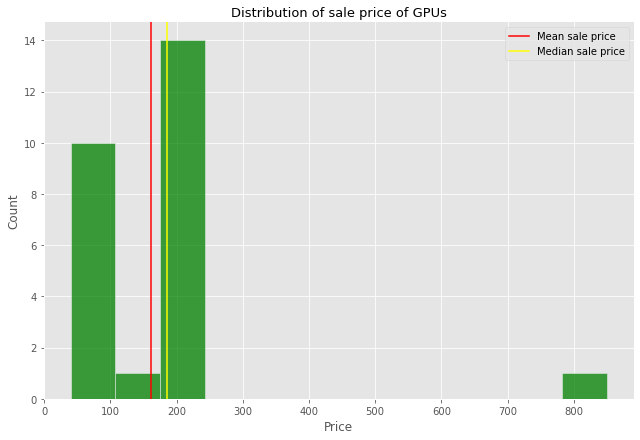

In [83]:
# plt.figure(figsize=(99,99))
sns.displot(GPU_df_no_reviews['Price'], bins=12, aspect=1.5, height=6, color='green')
plt.axvline(GPU_df_no_reviews['Price'].mean(),color='red')
plt.axvline(GPU_df_no_reviews['Price'].median(),color='yellow')

plt.title('Distribution of sale price of GPUs', size=13)
plt.legend(['Mean sale price','Median sale price']);

The distribution shows a right skewed graph with most of the GPUs falling below the 100 dollars range. The mean and the median prices are far part showing that they are some outliers in the price distribution as seen in the price range of 800 and 1000 dollars range. 

### Distribution of AMD and Nvidia Chipsets

In [84]:
GPU_df_no_reviews['Chipset Brand'].value_counts(normalize=True)

Nvidia    0.730769
Amd       0.269231
Name: Chipset Brand, dtype: float64

It seems that most of the GPUs are under Nvidia with a proportion of 70% while Amd has a proportion of 30%.

### Most popular brands by their rating

In [85]:
GPU_df_no_reviews['Manufacturer'].value_counts()

Gigabyte      6
Asus          6
MSI           5
VisionTek     2
EVGA          2
PowerColor    1
NVIDIA        1
PNY           1
Zotac         1
Diamond       1
Name: Manufacturer, dtype: int64

As NVIDIA, NVIDIA Corporation and Althon Micro Inc. have only 1 GPUs, I'll not include them in the popular brand investigation

In [86]:
manufacturer_list = ['AMD','ASRock','Aiposen','SAPPHIRE', 'Althon Micro Inc.', 'NVIDIA']
GPU_df_no_reviews.groupby('Manufacturer').mean().drop(manufacturer_list)['Overall Customer Rating'].sort_index(ascending=False).plot(kind='barh', 
                                                                                                                                            title='Most popular brand by rating', 
                                                                                                                                            figsize=(11,7), 
                                                                                                                                            color='green')
plt.xlabel('Rating')
plt.ylabel('Brand', rotation=360);

KeyError: "['AMD' 'ASRock' 'Aiposen' 'SAPPHIRE' 'Althon Micro Inc.'] not found in axis"

In [87]:
GPU_df_no_reviews.groupby('Manufacturer').mean().drop(manufacturer_list)['Overall Customer Rating'].sort_values(ascending=False)

KeyError: "['AMD' 'ASRock' 'Aiposen' 'SAPPHIRE' 'Althon Micro Inc.'] not found in axis"

Without including Nvidia and Althon Micro Inc as they have only 1 type of GPU, Asus, EVGA and SAPPHIRE are the most popular brands given their high ratings.

The reason behind this is that consumers usually prefer 3rd party coolers fitted into the GPUs compared to the Nvidia's coolers as they're much more effective in controlling the airflow and decreasing the GPU temperature. 

### Which Chipset Brand has a higher customer rating?

In [88]:
GPU_df_no_reviews.groupby('Chipset Brand').mean()['Overall Customer Rating']

Chipset Brand
Amd       4.400000
Nvidia    4.584211
Name: Overall Customer Rating, dtype: float64

Nvidia is slightly ahead of AMD in terms of the Overall Customer rating.

### Which Manufacturer produces GPUs with higher Memory Speed and Size?

In [89]:
GPU_df_no_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GPU Name                 26 non-null     object 
 1   Manufacturer             26 non-null     object 
 2   Chipset Brand            26 non-null     object 
 3   Memory Size              26 non-null     object 
 4   Memory Speed(MHz)        26 non-null     float64
 5   Price                    26 non-null     float64
 6   Overall Customer Rating  26 non-null     float64
 7   isenglish                26 non-null     int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 1.8+ KB


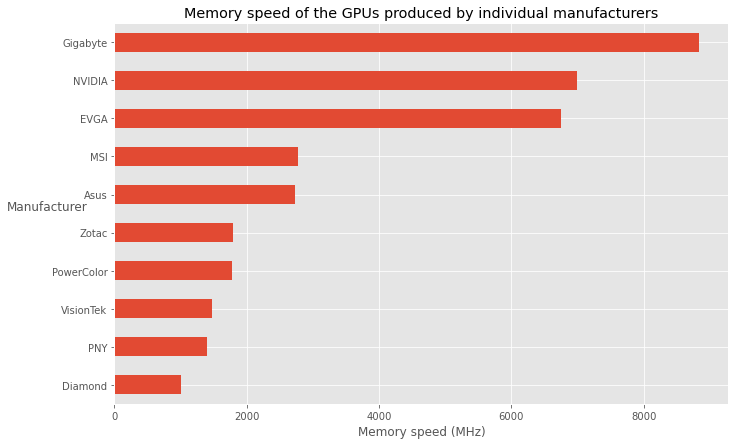

In [90]:
GPU_df_no_reviews.groupby('Manufacturer').mean()['Memory Speed(MHz)'].sort_values().plot(kind='barh', figsize=(11,7))

plt.title('Memory speed of the GPUs produced by individual manufacturers')
plt.xlabel('Memory speed (MHz)')
plt.ylabel('Manufacturer',rotation=360);

In [91]:
GPU_df_no_reviews.groupby('Manufacturer').mean()['Memory Speed(MHz)'].sort_values(ascending=False)

Manufacturer
Gigabyte      8837.333333
NVIDIA        7000.000000
EVGA          6753.000000
MSI           2777.600000
Asus          2729.666667
Zotac         1785.000000
PowerColor    1770.000000
VisionTek     1472.500000
PNY           1395.000000
Diamond       1000.000000
Name: Memory Speed(MHz), dtype: float64

ASRock, Gigabyte, XFX and EVGA manufacturers produces GPUs with high amount of memory speed which shows that they're premium brands that produce 'Enthusiast Grade' types of GPUs.

### EDA on Customer Review Title

In [92]:
customer_review_title = " ".join(GPU_df['Customer Review Title'])

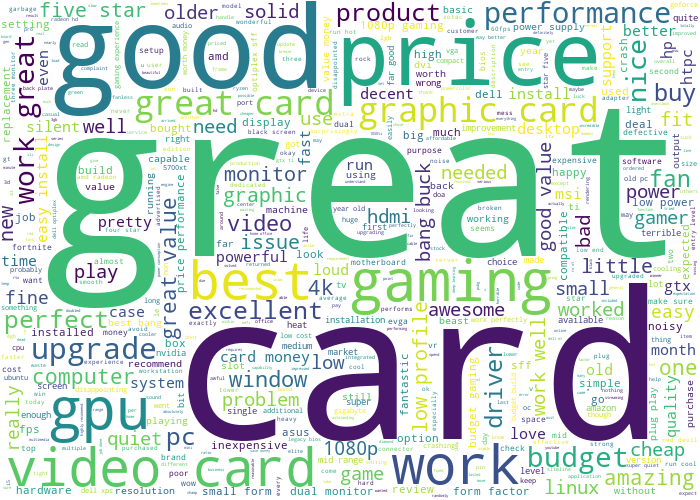

In [93]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(customer_review_title)
# Visualize the word cloud
wordcloud.to_image()

Based on the word cloud, it seems that consumers are mostly satisfied with their GPU purchase with 'good', 'great' and 'best' words coming out at the top. The consumers are mostly gamers and most of them play in 1080p resolution and they seem to be price sensitive with the words such as 'bang buck' and 'great value' having a bigger size. 

In [94]:
customer_review_title_list = customer_review_title.split()
customer_review_title_dict = {}

for word in customer_review_title_list:
    if word not in customer_review_title_dict.keys():
        customer_review_title_dict[word] = customer_review_title_list.count(word)
    else:
        continue
        
customer_review_title_dict

{'inexpensive': 12,
 'work': 164,
 'great': 437,
 'small': 35,
 'form': 15,
 'factor': 16,
 'pc': 51,
 'faster': 5,
 'powerful': 17,
 '10': 38,
 'year': 16,
 'old': 29,
 'gateway': 2,
 'desktop': 16,
 'fit': 24,
 'like': 30,
 'dream': 2,
 'hdmi': 26,
 'sound': 4,
 'went': 6,
 '4': 10,
 'week': 2,
 'fine': 18,
 'play': 32,
 'fortnite': 7,
 'lowest': 1,
 'setting': 12,
 '1080p': 35,
 'video': 116,
 'dy': 1,
 '4k': 34,
 '710': 2,
 'low': 73,
 'cost': 13,
 'product': 45,
 'window': 38,
 'fall': 1,
 'creator': 2,
 'update': 4,
 'build': 20,
 '1709': 1,
 'support': 15,
 'weak': 2,
 'performance': 71,
 'job': 15,
 'well': 44,
 'fan': 40,
 'barring': 1,
 'fried': 1,
 'le': 6,
 '8': 7,
 'month': 17,
 'rma': 3,
 'garbage': 5,
 'super': 12,
 'quick': 2,
 'start': 2,
 'hesitate': 1,
 'business': 3,
 'use': 20,
 'card': 496,
 'best': 87,
 'get': 27,
 'done': 4,
 'dual': 18,
 'monitor': 46,
 'dell': 26,
 'optiplex': 12,
 'far': 18,
 'good': 224,
 'maybe': 4,
 'real': 3,
 'gaming': 128,
 'cheap': 20,

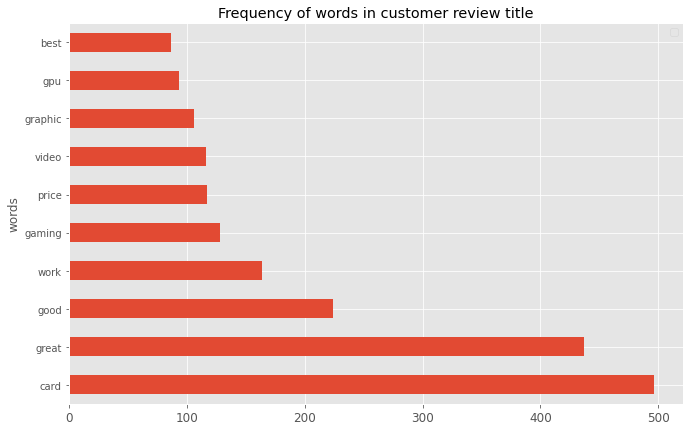

In [95]:
df = {'words': customer_review_title_dict.keys(), 'freq': customer_review_title_dict.values()}
customer_review_title_df = pd.DataFrame(df)
customer_review_title_df.sort_values('freq', ascending=False).set_index('words').head(10).plot(kind='barh', figsize=(11,7),
                                                                                              title='Frequency of words in customer review title')
plt.xticks(fontsize=12)
plt.legend([]);

The graph shows consistency with the word cloud on the frequency of the words appearing in the customer review title.

In [ ]:
# customer_review_title_df['freq'].hist(bins=150)
# plt.xlim(0,50)

### EDA on Customer Review

In [96]:
customer_review = " ".join(GPU_df['Customer Review'])

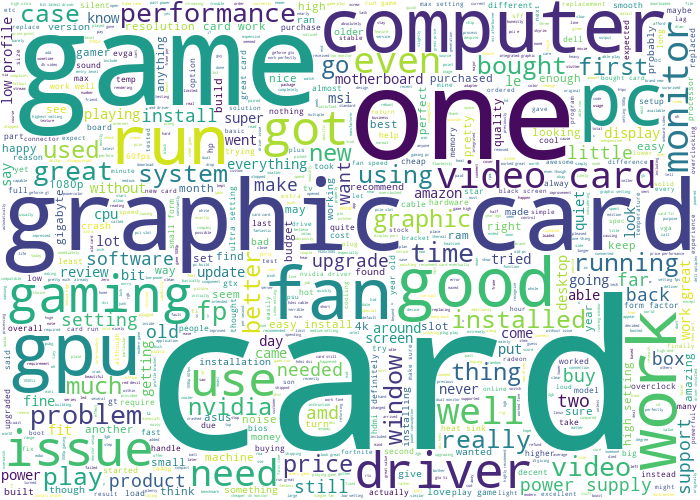

In [97]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(customer_review)
# Visualize the word cloud
wordcloud.to_image()

Similar to the customer review title word cloud, consumers who purchase GPUs tend to be gamers and they play on 1080p resolution. GPU fans are an important factor when making a GPU purchase as the word 'fan' size is rather big. The word 'issue' and 'problem' shows up big which suggests that consumers may have encountered issues with the GPUs they have purchased. The two brands 'amd' and 'nvidia' shows that these 2 are the major players in the GPU market. GPU drivers seem to play an important role in making sure that the GPU is functioning.

In [98]:
customer_review_list = customer_review.split()
customer_review_dict = {}

for word in customer_review_list:
    if word not in customer_review_dict.keys():
        customer_review_dict[word] = customer_review_list.count(word)
    else:
        continue
        
customer_review_dict

{'need': 346,
 'graphic': 896,
 'card': 3919,
 'upgrade': 281,
 'old': 389,
 'compact': 22,
 'desktop': 165,
 'pc': 608,
 'acer': 21,
 'aspire': 7,
 'a3910': 1,
 '2010': 5,
 'msi': 200,
 'geforce': 155,
 'gt': 128,
 '710': 63,
 'entry': 29,
 'level': 93,
 'fit': 243,
 'requirement': 37,
 'perfectly': 110,
 'several': 58,
 'reason': 71,
 'picked': 20,
 'instead': 63,
 'something': 121,
 'powerful': 56,
 'relatively': 15,
 'inexpensive': 30,
 'low': 378,
 'profile': 180,
 'occupies': 3,
 'one': 661,
 'pci': 77,
 'slot': 221,
 'important': 16,
 'since': 174,
 'sff': 92,
 'small': 184,
 'form': 85,
 'factor': 76,
 'case': 310,
 'limited': 24,
 'space': 54,
 'consumes': 8,
 'little': 203,
 'power': 571,
 '20w': 5,
 'max': 148,
 'even': 391,
 '220w': 3,
 'supply': 214,
 'handle': 86,
 'us': 42,
 'heatsink': 35,
 'passive': 19,
 'cooling': 82,
 'eliminates': 1,
 'noise': 135,
 'reliability': 6,
 'problem': 350,
 'associated': 4,
 'fan': 648,
 'installation': 118,
 'confusion': 3,
 'initially'

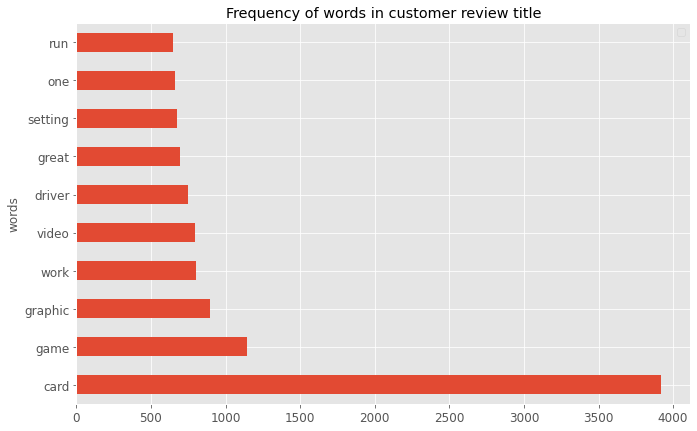

In [99]:
review_df = {'words': customer_review_dict.keys(), 'freq': customer_review_dict.values()}
customer_review_df = pd.DataFrame(review_df)
customer_review_df.sort_values('freq', ascending=False).set_index('words').head(10).plot(kind='barh', figsize=(11,7),
                                                                                              title='Frequency of words in customer review title')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend([]);

The graph shows consistency with the word cloud on the frequency of the words appearing in the customer review title.

## Prepare data for LDA Analysis

I'll be using only Customer Review to conduct the LDA Analysis as it makes up the bulk of the words.

In [100]:
# Converting to the customer reviews from series to a list.
data = GPU_df['Customer Review'].values.tolist()
data[600]

'running believe dell t710 tower version limited 1x slot worked intended seen anything wrong running two monitor flawlessly good picture lag greatly enhanced onboard video run two monitor projector still preformed expected using three output went knowing gaming video running hd shutter would buy least another one running 8 monitor lol'

In [101]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(sentence))

In [102]:
texts = list(sent_to_words(data))

In [103]:
# Prints the first document with up to 30 words in them
print(texts[:1][0][:30])

['need', 'graphic', 'card', 'upgrade', 'old', 'compact', 'desktop', 'pc', 'acer', 'aspire', 'msi', 'geforce', 'gt', 'entry', 'level', 'graphic', 'card', 'fit', 'requirement', 'perfectly', 'several', 'reason', 'picked', 'card', 'instead', 'something', 'powerful', 'relatively', 'inexpensive', 'low']


In [104]:
# Create Dictionary
id2word = corpora.Dictionary(texts)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 3), (11, 12), (12, 2), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 6), (24, 1), (25, 1), (26, 2), (27, 1), (28, 2), (29, 1)]


## LDA Model Training

In [105]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      passes=20, random_state=42)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"card" + 0.015*"driver" + 0.015*"video" + 0.013*"monitor" + '
  '0.012*"window" + 0.009*"use" + 0.009*"one" + 0.008*"graphic" + '
  '0.008*"computer" + 0.008*"running"'),
 (1,
  '0.034*"game" + 0.028*"card" + 0.028*"setting" + 0.027*"fps" + 0.016*"run" + '
  '0.015*"high" + 0.014*"play" + 0.012*"gb" + 0.010*"graphic" + '
  '0.010*"gaming"'),
 (2,
  '0.018*"card" + 0.014*"work" + 0.012*"support" + 0.012*"monitor" + '
  '0.007*"screen" + 0.007*"window" + 0.007*"get" + 0.007*"install" + '
  '0.006*"video" + 0.006*"would"'),
 (3,
  '0.012*"card" + 0.010*"video" + 0.007*"easy" + 0.006*"using" + 0.006*"work" '
  '+ 0.005*"son" + 0.005*"case" + 0.005*"price" + 0.005*"great" + '
  '0.005*"fast"'),
 (4,
  '0.039*"card" + 0.016*"fan" + 0.009*"work" + 0.009*"driver" + '
  '0.009*"graphic" + 0.008*"issue" + 0.008*"one" + 0.007*"time" + '
  '0.006*"would" + 0.006*"computer"'),
 (5,
  '0.040*"card" + 0.019*"video" + 0.014*"power" + 0.013*"work" + '
  '0.013*"driver" + 0.010*"computer" 

In [106]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+'ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if False:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '\\visualization\\' + 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.009701 -0.012400       1        1  25.100069
9      0.004393 -0.011183       2        1  16.223855
6      0.009262 -0.006597       3        1  12.630738
0      0.003570  0.003860       4        1  10.721018
1      0.008150  0.014571       5        1  10.420414
2      0.010363  0.006610       6        1   7.301777
4      0.011594  0.024526       7        1   7.164593
3     -0.000702 -0.026288       8        1   3.985712
5     -0.015439  0.000351       9        1   3.569680
8     -0.040892  0.006552      10        1   2.882144, topic_info=        Term         Freq        Total Category  logprob  loglift
10      card  4654.000000  4654.000000  Default  30.0000  30.0000
180   driver   765.000000   765.000000  Default  29.0000  29.0000
257      fan   908.000000   908.000000  Default  28.0000  28.0000
115  setting   732.000000   732.000000  Default  27.0000  27.0000
63     issue   586.000000   586.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
132     time    13.084542   477.671736  Topic10  -5.6250  -0.0509
48      game    19.045810  1409.413565  Topic10  -5.2496  -0.7574
63     issue    13.381423   586.655933  Topic10  -5.6026  -0.2339
55   graphic    12.948862   792.797686  Topic10  -5.6354  -0.5679
86       one    12.694043   800.593640  Topic10  -5.6553  -0.5976

[826 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
7547      3  0.549658       aceptable
6013      8  0.687806  acknowledgment
7719      3  0.549561      activating
3994      1  0.231431         adaptor
3994      2  0.115716         adaptor
...     ...       ...             ...
593       9  0.047690             yet
593      10  0.019076             yet
5675      1  0.909213              yo
6849      6  0.609861             zen
2147      9  0.680875              zi

[2108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 7, 1, 2, 3, 5, 4, 6, 9])

# Others

## Testing function (Working for now)

In [ ]:
# #def scrape_gpu(no_page, no_gpu, no_review_page):

# # Create the Chrome Driver object
# driver = webdriver.Chrome()

# # Id for GPU tracking
# ids = 1

# # To keep track of the last entry appended for the review titles and body and the rating
# idx_title = 0
# idx_body = 0
# idx_star = 0
# #print('Over sas')

# for page in range(1,3):
#     # Gets the first page of the website
#     #print('Over ss')
#     driver.get(f'https://www.amazon.com/s?k=Computer+Graphics+Cards&i=computers&rh=n:284822&page={page}&_encoding=UTF8&c=ts&qid=1608032958&ts_id=284822')
#     main_url = driver.current_url
#     #print('Over here')

#     # # Check for sponsored post
#     sponsored_posts = driver.find_elements_by_xpath('//div[@data-component-type="sp-sponsored-result"]/../../../..')
#     lst_index_sponsored = []
#     # Loop through the sponsored posts to find the index of the sponsored product
#     for post in sponsored_posts:
#         lst_index_sponsored.append(int(post.get_attribute('data-index')))

#     n = 0 # index number

#     # Scrap 3 GPUs in the first page
#     while n < 3:

#         # If the index is in sponsored list
#         while n in lst_index_sponsored:
#             print(f'{n} index is a Sponsored Product, will skip to the next product')
#             n += 1

#         # Wait for 1 seconds
#         time.sleep(1)
        
#         try:
#             # Click the link for the nth GPU
#             driver.find_element_by_xpath(f'//div[@data-index={str(n)}]//a[@class="a-link-normal a-text-normal"]').click()
#         except NoSuchElementException:
#             break

#         # Gets the url of the main page of the GPU
#         gpu_url = driver.current_url

#         # Click on the "See all reviews" link
#         try:
#             driver.find_element_by_xpath('//a[@data-hook="see-all-reviews-link-foot"]').click()
#         except NoSuchElementException:
#             n += 1
#             # Go back to the main page
#             driver.get(main_url)
#             continue # Go back to the start of the while loop

#         # Wait for 1 seconds
#         time.sleep(1)


#         """
#         Loop through the review page and obtain the review title, review body, ratings
#         """

#         # Number of review pages to loop through for each GPU
#         for review_page in range(2):

#             # Gets the title of the reviews for each page, selects only the first span if there are multiple spans
#             title_comment = driver.find_elements_by_xpath('//*[@data-hook = "review-title"]/span[1]')

#             # Gets the customer reviews for each page
#             review_body = driver.find_elements_by_xpath('//*[@data-hook = "review-body"]')


#             # Loop through the title comments and append it to the Customer Review Title
#             for title in title_comment:
#                 GPU_df.loc[idx_title, 'Customer Review Title'] = title.text
#                 idx_title += 1
#                 #print(f'Customer review title is {title.text}')

#             # Gets the review_bodies in the page and stores them in a list
#             review_list = [review.text for review in review_body]


#             # Loop through the review comments and append it to the Customer Review
#             for review in review_list:
#                 GPU_df.loc[idx_body, 'Customer Review'] = review
#                 idx_body += 1

#             # Sleep
#             time.sleep(1)

#             # Goes to the next review page   
#             try:
#                 driver.find_element_by_xpath('//li[@class="a-last"]/a').click()
#                 # Sleep
#                 time.sleep(3)
#             # If not break out of the loop, and go back to the GPU main page
#             except NoSuchElementException:
#                 break




#         """
#         Fill up the null values with their respective attributes
#         """

#         # Go back to the GPU main page
#         driver.get(gpu_url)

#         # Wait for 2 seconds
#         time.sleep(2)

#         # Fill up the null values with the GPU name
#         GPU_df['GPU Name'].fillna(driver.find_element_by_xpath('//*[@id="productTitle"]').text, inplace=True)

#         # Fill up the null values with the Chipset Brand
#         try:
#             chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Chipset Brand")]/../../td').text
#             GPU_df['Chipset Brand'].fillna(chipset,inplace=True)
#         except NoSuchElementException:
#             GPU_df['Chipset Brand'].fillna(np.nan,inplace=True)

#         # Fill up the null values with the Memory Size
#         try:
#             chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Graphics Card Ram Size")]/../../td').text
#             GPU_df['Memory Size'].fillna(chipset,inplace=True)
#         except NoSuchElementException:
#             GPU_df['Memory Size'].fillna(np.nan,inplace=True)

#         # Fill up the null values with the Memory Speed(MHz)
#         try:
#             chipset = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_1"]/tbody//text()[contains(.,"Memory Speed")]/../../td').text
#             GPU_df['Memory Speed(MHz)'].fillna(chipset,inplace=True)
#         except NoSuchElementException:
#             GPU_df['Memory Speed(MHz)'].fillna(np.nan,inplace=True)

#         # Fill up the null values with the manufacturer name
#         try:
#             manufacturer = driver.find_element_by_xpath('//*[@id="productDetails_techSpec_section_2"]/tbody//th[contains(text(),"Manufacturer")]/../td').text
#             GPU_df['Manufacturer'].fillna(manufacturer, inplace=True)
#         except NoSuchElementException:
#             GPU_df['Manufacturer'].fillna(np.nan,inplace=True)

#         # Fill up the null values with the Price
#         try:
#             GPU_df['Price'].fillna(driver.find_element_by_xpath('//*[@id="price_inside_buybox"]').text, inplace=True)
#         except NoSuchElementException:
#              GPU_df['Price'].fillna(np.nan, inplace=True)

#         # Fill up the null values with the Customer ratings
#         try:
#             # Gets the overall customer ratings
#             GPU_df['Overall Customer Rating'].fillna(driver.find_element_by_xpath('//div[@id="averageCustomerReviews"]//span[@id="acrPopover"]').get_attribute('title'), inplace=True)
#         except NoSuchElementException:
#             GPU_df['Overall Customer Rating'].fillna(np.nan, inplace=True)

#         # Fill the id of the GPU for tracking
#         GPU_df['id'].fillna(ids,inplace=True)
#         ids += 1

#         print(f'Completed scraping for {n} index in page {page}')

#         # Increases the index for the next GPU
#         n += 1

#         # Go back to the main page
#         driver.get(main_url)

#     print('*'*30)
#     print(f'Completed scraping for page {page}')
#     print('*'*30)

# # Close the browser session
# total_gpu = max(GPU_df['id'])
# print(f'Completed scraping {total_gpu} GPUs reviews for {page} pages')
# driver.quit()

# Testing the review body for the page

In [ ]:
# # Testing the review body for the page


# # Create the Chrome Driver object
# driver = webdriver.Chrome() 
# driver.get('https://www.amazon.com/Gigabyte-Radeon-Gaming-Graphic-GV-RX580GAMING-8GD/product-reviews/B0842VMKM5/ref=cm_cr_getr_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2')

# # Count the number of Spans in the "Review Body" class, if more than 1, put it in a list and use "".join()
# # before appending it to the dataframe
# more_than_1 = driver.find_elements_by_xpath('///span[@data-hook="review-body"][count(./span) > 1]/span')
# review_body = driver.find_elements_by_xpath('//*[@data-hook = "review-body"]/span')

# # If there is a review that is split into multiples span
# if more_than_1: 
#     # Holds the list of reviews
#     review_list = []
#     for review in more_than_1:
#         review_list.append(review.text) # Append it into a list
#     GPU_df.loc[idx_body, 'Customer Review'] = "".join(review_list)
#     idx_body += 1
#     for review in review_body[len(more_than_3)+1:]: # Reviews with one span
#         GPU_df.loc[idx_body, 'Customer Review'] = review.text
#         idx_body += 1
# else:
#     # Loop through the review comments and append it to the Customer Review
#     for review in review_body:
#         GPU_df.loc[idx_body, 'Customer Review'] = review.text
#         idx_body += 1
    
        
# # Wait for 2 seconds
# time.sleep(2)
# driver.quit()

## Testing the review body using for loop

In [ ]:
# # Testing the review body for the page


# # Create the Chrome Driver object
# driver = webdriver.Chrome() 
# driver.get('https://www.amazon.com/MSI-GT-710-2GD3-LP/product-reviews/B01DOFD0G8/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews')


# review_body = driver.find_elements_by_xpath('//*[@data-hook = "review-body"]/span')

# # Get all the reviews 
# reviews = driver.find_elements_by_xpath('//span[@data-hook="review-body"]')
# review_list = [x.text for x in reviews]
# print([x.text for x in reviews])

# for review in review_list:
#     GPU_df.loc[idx_body, 'Customer Review'] = review
#     idx_body += 1
            
# # Wait for 2 seconds
# time.sleep(2)
# driver.quit()

In [ ]:
# review_list[2]

In [ ]:
# GPU_df

In [ ]:
# GPU_df['Customer Review'].loc[41]

# Testing the star ratings of the comment for the page

In [ ]:
# # Testing the star ratings of the comment for the page

# # Holds the list of reviews
# list_of_stars = []

# # Create the Chrome Driver object
# driver = webdriver.Chrome() 
# driver.get('https://www.amazon.com/XFX-Radeon-1386MHz-Graphics-RX-580P8DFD6/dp/B06Y66K3XD/ref=cm_cr_arp_d_bdcrb_top?ie=UTF8&th=1')


# star_ratings = driver.find_element_by_xpath('//div[@id="averageCustomerReviews"]//span[@id="acrPopover"]').get_attribute('title')

# # Get the Profile name 
# # star_ratings = driver.find_elements_by_xpath('//div[@data-hook="review"]//span[@class= "a-profile-name"]')


# # For individual customer reviews
# # for star in star_ratings:
# #     list_of_stars.append(star.get_attribute('title'))
    
# # Wait for 2 seconds
# time.sleep(2)
# driver.quit()

In [ ]:
# star_ratings

In [ ]:
# GPU_df.loc[6] = ['','','','','','']
# GPU_df.loc[7]